In [1]:
import pandas as pd 
import numpy as np
import joblib
import time
import sklearn.metrics
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

## Load Data

In [2]:
## Original dataset + TabGAN
train = pd.read_csv('./DS/train_SFS.csv')

X_train = train.drop(['Label'], axis=1)
y_train = train['Label']

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_train = pd.Series(y_train).astype(np.float32)

train_tgan = pd.read_csv('./DS/new_TGAN.csv')
X_train_tgan = train_tgan.drop('Label', axis=1)
y_train_tgan = train_tgan['Label']

X_train =  pd.concat([X_train, X_train_tgan], ignore_index=True)
y_train =  pd.concat([y_train, y_train_tgan], ignore_index=True)

X_test = pd.read_csv('./DS/X_test_SFS.csv')
y_test = pd.read_csv('./DS/y_test_SFS.csv')

def calculate_macro_tpr_fpr(voting_cm):
    num_classes = voting_cm.shape[0]
    tpr_list = []
    fpr_list = []

    for i in range(num_classes):
        TP = voting_cm[i, i]
        FN = np.sum(voting_cm[i, :]) - TP
        FP = np.sum(voting_cm[:, i]) - TP
        TN = np.sum(voting_cm) - (TP + FN + FP)

        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0

        tpr_list.append(TPR)
        fpr_list.append(FPR)

    macro_tpr = np.mean(tpr_list)
    macro_fpr = np.mean(fpr_list)

    return macro_tpr, macro_fpr

## XGB

In [24]:
xgb_params = {
    'device': 'cuda',
    'max_depth': 128,
    # 'n_estimators': 6400,
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'learning_rate': 0.1,
    'eval_metric': 'auc'
}


print("XGBClassifier Starting")
xgb_model = XGBClassifier(**xgb_params)
xgb_model.fit(X_train,y_train)
# joblib.dump(xgb_model, './models/TGAN_XGB.pkl')
# xgb_model = joblib.load('./models/TGAN_XGB.pkl')
xgb_start_time = time.time()
xgb_prediction = xgb_model.predict(X_test)
xgb_end_time = time.time()
xgb_time = xgb_end_time - xgb_start_time
print("XGBClassifier Finished")

xgb_acc = sklearn.metrics.accuracy_score(xgb_prediction, y_test)
xgb_precision = sklearn.metrics.precision_score(xgb_prediction, y_test, average='macro')
xgb_f1 = sklearn.metrics.f1_score(xgb_prediction, y_test, average='macro')
xgb_recall = sklearn.metrics.recall_score(xgb_prediction, y_test, average='macro')
xgb_cm = sklearn.metrics.confusion_matrix(xgb_prediction, y_test)
xgb_probs = xgb_model.predict_proba(X_test)
xgb_auc = sklearn.metrics.roc_auc_score(y_test, xgb_probs, average='macro', multi_class='ovr')
xgb_tpr, xgb_fpr = calculate_macro_tpr_fpr(xgb_cm)
print("XGBoost report:")
print("XGBoost Time:", xgb_time)
print("XGBoost Accuracy:", xgb_acc)
print("XGBoost Precision:", xgb_precision)
print("XGBoost F1:", xgb_f1)
print("XGBoost Recall:", xgb_recall)
print("XGBoost ROC AUC:", xgb_auc)
print("XGBoost CM:\n", xgb_cm)
print(f'XGBoost Macro-average TPR: {xgb_tpr}')
print(f'XGBoost Macro-average FPR: {xgb_fpr}')

XGBClassifier Starting
XGBClassifier Finished
XGBoost report:
XGBoost Time: 0.044188499450683594
XGBoost Accuracy: 0.8392504930966469
XGBoost Precision: 0.8392504930966469
XGBoost F1: 0.8330574994924045
XGBoost Recall: 0.8327500296186683
XGBoost ROC AUC: 0.9860749931300683
XGBoost CM:
 [[169   0   0   0   0   0   0   0   0   0   0   0]
 [  0 169   0   0   0   0   0   1   0   2   0   0]
 [  0   0 169   0   0   0   0  39   0  10   0   0]
 [  0   0   0 169   0   0   0   0   0   0   0   0]
 [  0   0   0   0 169   1   0   2   0   0   0   0]
 [  0   0   0   0   0 168   0   0   0   0   0   0]
 [  0   0   0   0   0   0 169   1   0   0   0   1]
 [  0   0   0   0   0   0   0  59  51   5   0   0]
 [  0   0   0   0   0   0   0  43 118   0   0   0]
 [  0   0   0   0   0   0   0   8   0  97  91   0]
 [  0   0   0   0   0   0   0  16   0  55  78   0]
 [  0   0   0   0   0   0   0   0   0   0   0 168]]
XGBoost Macro-average TPR: 0.8327500296186683
XGBoost Macro-average FPR: 0.014468704357554674


## ET

In [43]:
et_params = {
    "n_estimators": 27,
    "max_leaf_nodes": 15000,
    "n_jobs": -1,
    "random_state": 0,
    "bootstrap": True,
    "criterion": "entropy"
}

print("ExtraTreesClassifier Starting")
et_model = ExtraTreesClassifier(**et_params)
et_model.fit(X=X_train, y=y_train)
# joblib.dump(et_model, './models/TGAN_ET.pkl')
# et_model = joblib.load('./models/TGAN_ET.pkl')
et_start_time = time.time()
et_prediction = et_model.predict(X_test)
et_end_time = time.time()
et_time = et_end_time - et_start_time
print("ExtraTreesClassifier Finished")

et_acc = sklearn.metrics.accuracy_score(et_prediction, y_test)
et_precision = sklearn.metrics.precision_score(et_prediction, y_test, average='macro')
et_f1 = sklearn.metrics.f1_score(et_prediction, y_test, average='macro')
et_recall = sklearn.metrics.recall_score(et_prediction, y_test, average='macro')
et_cm = sklearn.metrics.confusion_matrix(et_prediction, y_test)
et_probs = et_model.predict_proba(X_test)
et_auc = sklearn.metrics.roc_auc_score(y_test, et_probs, average='macro', multi_class='ovr')
et_tpr, et_fpr = calculate_macro_tpr_fpr(et_cm)
print("ExtraTrees report:")
print("ExtraTrees Time:", et_end_time - et_start_time)
print("ExtraTrees Accuracy:", et_acc)
print("ExtraTrees Precision:", et_precision)
print("ExtraTrees F1:", et_f1)
print("ExtraTrees Recall:", et_recall)
print("ExtraTrees ROC AUC:", et_auc)
print("ExtraTrees CM:\n", et_cm)
print(f'ExtraTrees Macro-average TPR: {et_tpr}')
print(f'ExtraTrees Macro-average FPR: {et_fpr}')

ExtraTreesClassifier Starting
ExtraTreesClassifier Finished
ExtraTrees report:
ExtraTrees Time: 0.0322268009185791
ExtraTrees Accuracy: 0.8584812623274162
ExtraTrees Precision: 0.8584812623274161
ExtraTrees F1: 0.8544345588361429
ExtraTrees Recall: 0.8572146375708948
ExtraTrees ROC AUC: 0.9838144142308912
ExtraTrees CM:
 [[169   0   0   0   0   0   0   0   0   0   0   0]
 [  0 169   0   0   0   0   0   1   0   0   0   0]
 [  0   0 169   0   0   0   0  27   0  12   0   0]
 [  0   0   0 169   0   0   0   0   0   0   0   0]
 [  0   0   0   0 169   0   0   0   0   0   0   0]
 [  0   0   0   0   0 169   0   0   0   0   0   0]
 [  0   0   0   0   0   0 169   0   0   0   0   0]
 [  0   0   0   0   0   0   0  80  34   5   1   0]
 [  0   0   0   0   0   0   0  32 135   0   0   0]
 [  0   0   0   0   0   0   0  12   0 105  99   0]
 [  0   0   0   0   0   0   0  17   0  47  69   0]
 [  0   0   0   0   0   0   0   0   0   0   0 169]]
ExtraTrees Macro-average TPR: 0.8572146375708948
ExtraTrees Macr

## RF

In [38]:
rf_params = {
    "n_estimators": 11,
    "max_leaf_nodes": 15000,
    "n_jobs": -1,
    "random_state": 0,
    "bootstrap": True,
    "criterion": "entropy"
}

print("RandomForestClassifier Starting")
rf_model = RandomForestClassifier(**rf_params)
rf_model.fit(X=X_train, y=y_train)
# joblib.dump(rf_model, './models/TGAN_RF.pkl')
# rf_model = joblib.load('./models/TGAN_RF.pkl')
rf_start_time = time.time()
rf_prediction = rf_model.predict(X_test)
rf_end_time = time.time()
rf_time = rf_end_time - rf_start_time
print("RandomForestClassifier Finished")

rf_acc = sklearn.metrics.accuracy_score(rf_prediction, y_test)
rf_precision = sklearn.metrics.precision_score(rf_prediction, y_test, average='macro')
rf_f1 = sklearn.metrics.f1_score(rf_prediction, y_test, average='macro')
rf_recall = sklearn.metrics.recall_score(rf_prediction, y_test, average='macro')
rf_cm = sklearn.metrics.confusion_matrix(rf_prediction, y_test)
rf_probs = rf_model.predict_proba(X_test)
rf_auc = sklearn.metrics.roc_auc_score(y_test, rf_probs, average='macro', multi_class='ovr')
rf_tpr, rf_fpr = calculate_macro_tpr_fpr(rf_cm)
print("RandomForest report:")
print("RandomForest Time:", rf_end_time - rf_start_time)
print("RandomForest Accuracy:", rf_acc)
print("RandomForest Precision:", rf_precision)
print("RandomForest F1:", rf_f1)
print("RandomForest Recall:", rf_recall)
print("RandomForest ROC AUC:", rf_auc)
print("RandomForest CM:\n", rf_cm)
print(f'RandomForest Macro-average TPR: {rf_tpr}')
print(f'RandomForest Macro-average FPR: {rf_fpr}')

RandomForestClassifier Starting
RandomForestClassifier Finished
RandomForest report:
RandomForest Time: 0.021494388580322266
RandomForest Accuracy: 0.8545364891518737
RandomForest Precision: 0.8545364891518736
RandomForest F1: 0.8483186729730133
RandomForest Recall: 0.8506706529327289
RandomForest ROC AUC: 0.9802815717130692
RandomForest CM:
 [[169   0   0   0   0   0   0   0   0   0   0   0]
 [  0 169   0   0   0   0   0   1   0   2   0   0]
 [  0   0 169   0   0   0   0  37   0  12   0   0]
 [  0   0   0 169   0   0   0   3   0   2   0   0]
 [  0   0   0   0 169   0   1   6   0   0   0   0]
 [  0   0   0   0   0 169   0   0   0   0   0   0]
 [  0   0   0   0   0   0 168   3   0   0   0   0]
 [  0   0   0   0   0   0   0  70  36   5   0   0]
 [  0   0   0   0   0   0   0  25 133   0   0   0]
 [  0   0   0   0   0   0   0  10   0 104  94   0]
 [  0   0   0   0   0   0   0  14   0  44  75   0]
 [  0   0   0   0   0   0   0   0   0   0   0 169]]
RandomForest Macro-average TPR: 0.85067065

## Voting

In [16]:
xgb_model = XGBClassifier()
xgb_model = joblib.load('./models/TGAN_XGB.pkl')
et_model = ExtraTreesClassifier()
et_model = joblib.load('./models/TGAN_ET.pkl')
rf_model = RandomForestClassifier()
rf_model = joblib.load('./models/TGAN_RF.pkl')

xgb_preds = xgb_model.predict_proba(X_test)
et_preds = et_model.predict_proba(X_test)
rf_preds = rf_model.predict_proba(X_test)

xgb_prediction = xgb_model.predict(X_test)
et_prediction = et_model.predict(X_test)
rf_prediction = rf_model.predict(X_test)

xgb_acc = sklearn.metrics.accuracy_score(xgb_prediction, y_test)
et_acc = sklearn.metrics.accuracy_score(et_prediction, y_test)
rf_acc = sklearn.metrics.accuracy_score(rf_prediction, y_test)

print("XGBoost Accuracy:", xgb_acc)
print("ExtraTree Accuracy:", et_acc)
print("RandomForest Accuracy:", rf_acc)

/home/vvhoang/miniconda3/envs/test_env/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [20:52:43] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.8392504930966469
ExtraTree Accuracy: 0.8584812623274162
RandomForest Accuracy: 0.8545364891518737


In [17]:
avgs = (
    0.003 * xgb_preds
    + 0.872 * et_preds
    + 0.125 * rf_preds
)

voting_prediction = avgs.argmax(axis=1)
voting_acc = sklearn.metrics.accuracy_score(voting_prediction, y_test)
voting_precision = sklearn.metrics.precision_score(voting_prediction, y_test, average='macro')
voting_f1 = sklearn.metrics.f1_score(voting_prediction, y_test, average='macro')
voting_recall = sklearn.metrics.recall_score(voting_prediction, y_test, average='macro')
voting_cm = sklearn.metrics.confusion_matrix(voting_prediction, y_test)
voting_auc = sklearn.metrics.roc_auc_score(y_test, avgs, average='macro', multi_class='ovr')
macro_tpr, macro_fpr = calculate_macro_tpr_fpr(voting_cm)
print("Voting report:")
print("Voting Accuracy:", voting_acc)
print("Voting Precision:", voting_precision)
print("Voting F1:", voting_f1)
print("Voting Recall:", voting_recall)
print("Voting ROC AUC:", voting_auc)
print("Voting CM:\n", voting_cm)
print(f'Voting Macro-average TPR: {macro_tpr}')
print(f'Voting Macro-average FPR: {macro_fpr}')

Voting report:
Voting Accuracy: 0.8589743589743589
Voting Precision: 0.858974358974359
Voting F1: 0.854695353859222
Voting Recall: 0.8576899424743286
Voting ROC AUC: 0.9875171483045856
Voting CM:
 [[169   0   0   0   0   0   0   0   0   0   0   0]
 [  0 169   0   0   0   0   0   1   0   0   0   0]
 [  0   0 169   0   0   0   0  26   0  11   0   0]
 [  0   0   0 169   0   0   0   0   0   0   0   0]
 [  0   0   0   0 169   0   0   0   0   0   0   0]
 [  0   0   0   0   0 169   0   0   0   0   0   0]
 [  0   0   0   0   0   0 169   0   0   0   0   0]
 [  0   0   0   0   0   0   0  79  32   6   0   0]
 [  0   0   0   0   0   0   0  34 137   0   0   0]
 [  0   0   0   0   0   0   0  11   0 106 101   0]
 [  0   0   0   0   0   0   0  18   0  46  68   0]
 [  0   0   0   0   0   0   0   0   0   0   0 169]]
Voting Macro-average TPR: 0.8576899424743286
Voting Macro-average FPR: 0.012700377348861994


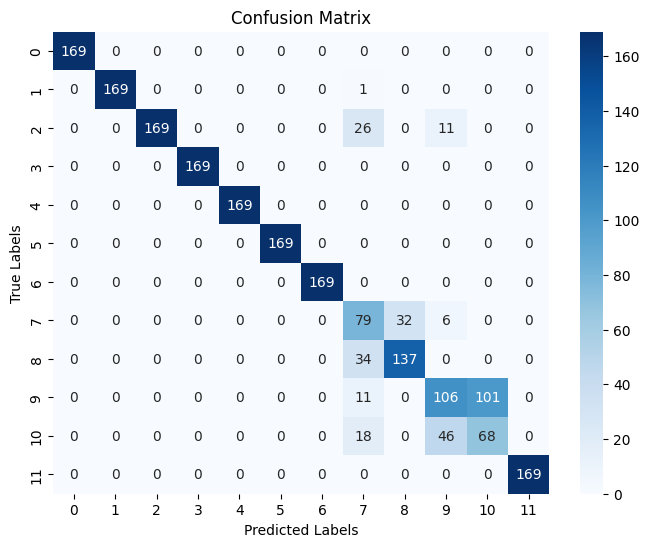

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(voting_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()